In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import yfinance as yf
import yahoo_fin.stock_info as si
from yahoo_fin import options
import time as time
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tpot import TPOTClassifier
from datetime import datetime
from sklearn.pipeline import make_pipeline
from dateutil.relativedelta import relativedelta
import yfinance as yf

In [62]:
tick = 'ABNB'
oldest_date = (datetime.today()+ relativedelta(months=-62)).strftime('%Y-%m-%d')
K = 4


stock = yf.Ticker(tick)
#analyst ratings
file_path_sent = r'C:\Users\Jerome\Desktop\Jerome_Ground\Stocker_Git\StockerVS\AISTOCK\Analyst_sent.txt'
analyst_mp = {}
with open(file_path_sent,'r') as file: 
    for line in file:
        key, value = line.strip().split(',')
        analyst_mp[key] = float(value)
recos = stock.upgrades_downgrades
recos = recos[recos.index.strftime('%Y-%m-%d') >= oldest_date].copy()
recos['To_Grade_weight'] = recos['ToGrade'].map(analyst_mp)
recos['From_Grade_weight'] = recos['FromGrade'].map(analyst_mp)
working = recos[['ToGrade', 'FromGrade', 'To_Grade_weight', 'From_Grade_weight']]
to_grade = working[['ToGrade', 'To_Grade_weight']].drop_duplicates('ToGrade')
to_grade = to_grade[to_grade['To_Grade_weight'].isna()]

from_grade = working[['FromGrade', 'From_Grade_weight']].drop_duplicates('FromGrade')
from_grade = from_grade[from_grade['From_Grade_weight'].isna()]

#Write for ToGrade
for sentiment in to_grade['ToGrade']:
    new_weight = input(f'Enter relevant weight "{sentiment}": ')
    analyst_mp[sentiment] = new_weight

#Write for FromGrade
for sentiment in from_grade['FromGrade']:
    if sentiment in analyst_mp.keys():
        pass
    else:
        new_weight = input(f'Enter relevant weight "{sentiment}": ')
        analyst_mp[sentiment] = new_weight

recos['To_Grade_weight'] = recos['ToGrade'].map(analyst_mp).astype('float')
recos['From_Grade_weight'] = recos['FromGrade'].map(analyst_mp).astype('float')

with open(file_path_sent, 'w') as file:
    for key, value in analyst_mp.items():
        file.write(f"{key},{value}\n")
recos['Month'] = recos['Firm'].index.strftime("%Y-%m")
mp_raw, mp_change  = {}, {}
mp_raw_list = []
mp_change_list = []
recos_values = recos.values
for i in recos.values:
    mp_raw[i[0]] = i[4]
    mp_change[i[0]] = i[4] - i[5]
    mp_raw_list.append(np.mean(list(mp_raw.values())))
    mp_change_list.append(np.mean(list(mp_change.values())))
recos['mp_raw'] = mp_raw_list
recos['mp_change'] = mp_change_list
anal_sent = recos[['Month','mp_raw', 'mp_change']]
anal_sent = anal_sent.drop_duplicates('Month', keep = 'last').reset_index(drop = True)

#Earnings scraper
earnings = stock.get_earnings_dates(limit = 26)
earnings.index = earnings.index.strftime('%Y-%m-%d')
earnings = earnings['Reported EPS'].dropna()

#Initialize dictionary list for scorekeeping
dict_list = []
min_num = 3
max_num = 3
for K in range(min_num,max_num + 1):
    data_new = stock.history(period = '31mo', interval ='1wk', auto_adjust = False)
    data_old = stock.history(period = '62mo', interval ='1wk', auto_adjust = False)
    def Prep(df, old):
        df = df.drop('Close', axis = 1, inplace = False)
        df['Dividends'] = df['Dividends']/df['Adj Close']
        if old == True:
            df = df.loc[~df.index.isin(data_new.index)]
        df['Month'] = df.index.month
        encoded_months = encoder.fit_transform(df[['Month']])
        encoded_months_df = pd.DataFrame(encoded_months, columns= encoder.get_feature_names_out(['Month']))
        encoded_months_df.index = df.index
        df = df.drop(columns = ['Month']).join(encoded_months_df)
        return df
    
    df_new_p = Prep(data_new, old = False).copy()
    df_old_p = Prep(data_old, old = True).copy()

    def Cal(data3):
        data3['Dividends'] = data3['Dividends']/data3['Adj Close']
        df = data3.copy()
        #Volatility
        df['volatility'] = df['Adj Close'].rolling(window = 12, min_periods = 12).std()


        #BOV
        dof = np.sign(df['Adj Close'] - df['Adj Close'].shift(1))
        Vol_Change = (df['Volume'] * dof)
        bov = Vol_Change.cumsum()
        df['BOV'] = bov.pct_change()


        Low_60 = df['Adj Close'].rolling(window = 60, min_periods = 60).min()
        High_60 = df['Adj Close'].rolling(window = 60, min_periods = 60).max()
        Dif = High_60 - Low_60
        def Low_cal(k):
            arr = Low_60 + (Dif * k)
            Parr = (df['Adj Close']/arr) -1
            return Parr
        def High_cal(j):
            arr = High_60 - (Dif * j)
            Parr = (df['Adj Close']/arr) -1
            return Parr

        #Fibonnaci
        df['SF2'] = Low_cal(0.5)
        df['SF4'] = Low_cal(0.786)
        df['RC1'] = High_cal(0.786)

        #Boolinger
        df['SMA'] = df['Adj Close'].rolling(window = 20, min_periods = 20).mean()
        df['STD'] = df['Adj Close'].rolling(window = 20, min_periods = 20).std()
        df['LBol'] = df['SMA'] - (2* df['STD'])
        df['HBol'] = df['SMA'] + (2* df['STD'])
        df['PLbol'] = ((df['Adj Close'] - df['LBol']) / df['LBol']) 
        df['PHbol'] = ((df['Adj Close'] - df['HBol']) / df['HBol'])
        df.drop(['LBol','HBol','STD','SMA'], inplace = True, axis = 1)
        high_prices = df['High']
        close_prices = df['Adj Close']
        low_prices = df['Low']

        nine_period_high =  df['High'].rolling(window=9).max()
        nine_period_low = df['Low'].rolling(window=9).min()
        tenkan_sen = (nine_period_high + nine_period_low) /2

        period26_high = high_prices.rolling(window=26).max()
        period26_low = low_prices.rolling(window=26).min()
        kijun_sen = (period26_high + period26_low) / 2

        senkou_span_a = ((tenkan_sen + kijun_sen) / 2).shift(26)

        period52_high = high_prices.rolling(window=52).max()
        period52_low = low_prices.rolling(window=52).min()
        senkou_span_b = ((period52_high + period52_low) / 2).shift(26)

        df['kumo'] = senkou_span_a - senkou_span_b
        df['kijun_tenkan'] = tenkan_sen - kijun_sen
        ema12 = df['Adj Close'].ewm(span = 12,adjust=False, min_periods = 12).mean()
        ema26 = df['Adj Close'].ewm(span = 26,adjust=False, min_periods = 26).mean()
        MACD = ema12 - ema26
        df['MACD'] = MACD
        ema9 = df['MACD'].ewm(span = 9,adjust=False, min_periods = 9).mean()
        df['ema9'] = ema9
        df['MACD_Histogram'] = MACD - ema9
        df['MACD_grad'] = df['MACD'] - df['MACD'].shift(1)
        df['ema9_grad'] = df['ema9'] - df['ema9'].shift(1)
        cup = df['Adj Close'].diff().copy()
        cdown = df['Adj Close'].diff().copy()
        cup[cup < 0] = 0
        cdown[cdown > 0] = 0
        cup_sum = cup.rolling(14, min_periods = 14).sum()
        cdown_sum = cdown.rolling(14, min_periods = 14).sum() 
        rsi_cal = cup_sum / (cdown_sum * -1)
        RSI = 100 - (100/(1 + rsi_cal))
        df['RSI'] = RSI
        def wwma(values, n):
            return values.ewm(alpha=1/n, adjust=False).mean()

        def atr(df, n=14):
            data_work = df.copy()
            high = data_work['High']
            low = data_work['Low']
            close = data_work['Adj Close']
            data_work['tr0'] = abs(high - low)
            data_work['tr1'] = abs(high - close.shift())
            data_work['tr2'] = abs(low - close.shift())
            tr = data_work[['tr0', 'tr1', 'tr2']].max(axis=1)
            atr = wwma(tr, n)
            return atr
        df['atr'] = atr(df, 14)

        return df
    df = pd.concat([Cal(df_old_p), Cal(df_new_p)])
    def target_variable(df):
        direc = df['Adj Close'].shift(-K) - df['Adj Close']
        direc = direc.astype(object)
        direc[direc > 0] = 1
        direc[direc < 0] = 0
        direc[direc.isna()] = 'insf'
        return direc

    df['dir'] = target_variable(df)    
    df['Month'] = df.index.strftime('%Y-%m')
    df.index = df.index.strftime('%Y-%m-%d')
    index_holder = df.index
    df = df.merge(earnings, how = 'outer', left_index = True, right_index = True)
    df['Reported EPS'] = df['Reported EPS'].ffill()
    df.dropna(subset = ["Adj Close", "Volume"], inplace = True)
    df["Reported EPS"]  = df["Adj Close"] / df["Reported EPS"]

    df = pd.merge(df, anal_sent, on = 'Month', how = 'left').drop('Month', axis = 1)
    df.index = index_holder
    df[['mp_raw', 'mp_change']] = df[['mp_raw', 'mp_change']].ffill()

    len_dif = len(sp500_daily_change.index) - len(df.index)
    if len_dif > 0:
        newp500_daily_change = sp500_daily_change.drop(index = sp500_daily_change.index[:len_dif], axis = 0, inplace = False)
        newp500_daily_change.index = df.index
        df["Feels_goodline"] = newp500_daily_change
    else:
        sp500_daily_change.index = df.index
        df["Feels_goodline"] = sp500_daily_change

    df.drop(['Open','High','Low', 'Volume'], axis = 1, inplace = True)
    z = df.loc[((df['dir'].loc[df['dir'] == 'insf']).index)]
    z.drop(['dir','Adj Close'], inplace= True, axis = 1)

    df.dropna(inplace = True)
    df.drop(index = z.index, inplace = True, axis = 0)
    y = df['dir']
    y = y.astype('int')
    X = df.drop(['dir','Adj Close'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)
    input_shapes = [X_train.shape[0], X_test.shape[0]]
    tpot_pipeline = make_pipeline(StandardScaler(), TPOTClassifier(generations=10, population_size=50, verbosity=1, scoring = 'f1', n_jobs= 2, random_state= 42))
    tpot_pipeline.fit(X_train, y_train)
    
    y_pred = tpot_pipeline.predict(X_test)
    score_dict = {}
    roc_auc = roc_auc_score(y_test, y_pred)
    score_dict['ROC'] = round(roc_auc, 3)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    if tp == 0:
        tp_rate = 0
    else:
        tp_rate = (tp)/(fp + tp)
    if tn == 0:
        tn_rate = 0
    else:    
        tn_rate = (tn)/(fn + tn)
    train_score = tpot_pipeline.score(X_train, y_train)
    test_score = tpot_pipeline.score(X_test, y_test)

    score_dict['Train_score'] = round(train_score,3)
    score_dict['Test_score'] = round(test_score,3)

    score_dict['1'] = round(tp_rate, 3)
    score_dict['0'] = round(tn_rate, 3)
    score_dict['Prediction'] = tpot_pipeline.predict(z)
    score_dict['date'] = z.index
    dict_list.append(score_dict)


                Dividends  Stock Splits   Month_2   Month_3   Month_4  \
Dividends             NaN           NaN       NaN       NaN       NaN   
Stock Splits          NaN           NaN       NaN       NaN       NaN   
Month_2               NaN           NaN  1.000000 -0.078431 -0.088561   
Month_3               NaN           NaN -0.078431  1.000000 -0.088561   
Month_4               NaN           NaN -0.088561 -0.088561  1.000000   
Month_5               NaN           NaN -0.078431 -0.078431 -0.088561   
Month_6               NaN           NaN -0.088561 -0.088561 -0.100000   
Month_7               NaN           NaN -0.106948 -0.106948 -0.120761   
Month_8               NaN           NaN -0.078431 -0.078431 -0.088561   
Month_9               NaN           NaN -0.078431 -0.078431 -0.088561   
Month_10              NaN           NaN -0.088561 -0.088561 -0.100000   
Month_11              NaN           NaN -0.078431 -0.078431 -0.088561   
Month_12              NaN           NaN -0.078431 -

In [50]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
tick = 'ABNB'
oldest_date = (datetime.today()+ relativedelta(months=-62)).strftime('%Y-%m-%d')
K = 4

encoder = OneHotEncoder(drop = 'first', sparse_output = False)
stock = yf.Ticker(tick)
stock.history(period = '62mo', interval ='1wk', auto_adjust = False)
data_new = stock.history(period = '31mo', interval ='1wk', auto_adjust = False)
data_old = stock.history(period = '62mo', interval ='1wk', auto_adjust = False)
def Prep(df, old):
    df = df.drop('Close', axis = 1, inplace = False)
    df['Dividends'] = df['Dividends']/df['Adj Close']
    if old == True:
        df = df.loc[~df.index.isin(data_new.index)]
    df['Month'] = df.index.month
    print(df)
    encoded_months = encoder.fit_transform(df[['Month']])
    encoded_months_df = pd.DataFrame(encoded_months, columns= encoder.get_feature_names_out(['Month']))
    encoded_months_df.index = df.index
    df = df.drop(columns = ['Month']).join(encoded_months_df)
    return df
df_new_p = Prep(data_new, old = False).copy()
df_old_p = Prep(data_old, old = True).copy()



                                 Open        High         Low   Adj Close  \
Date                                                                        
2022-01-03 00:00:00-05:00  165.296997  175.899994  156.339996  166.050003   
2022-01-10 00:00:00-05:00  159.759995  171.990005  152.100006  163.990005   
2022-01-17 00:00:00-05:00  156.910004  165.199997  152.410004  156.729996   
2022-01-24 00:00:00-05:00  150.000000  152.399994  134.373993  142.770004   
2022-01-31 00:00:00-05:00  144.802994  157.389999  143.809998  155.559998   
...                               ...         ...         ...         ...   
2024-07-01 00:00:00-04:00  152.199997  155.210007  149.139999  152.500000   
2024-07-08 00:00:00-04:00  152.649994  155.660004  144.130005  146.779999   
2024-07-15 00:00:00-04:00  145.880005  151.639999  144.750000  147.990005   
2024-07-22 00:00:00-04:00  148.139999  151.250000  137.580002  140.100006   
2024-07-29 00:00:00-04:00  141.240005  142.429993  126.500000  128.229996   

In [5]:
confu_level= 0.5
confi_level = 0
roc_level = 0.6
filepath = r'C:\Users\Jerome\Desktop\Jerome_Ground\Stocker_Git\AI_STOCKS_LOG\test.txt'
with open(filepath, 'a') as file:
    for i in range(len(dict_list)):
        scores = dict_list[i]
        mp_tut = {1: 'Long', 0: 'Short'}
        n_predictions = len(scores['Prediction'])
        print(f"{tick}: For K = {i+min_num},prediction: {scores['Prediction']}, Confidence {scores['Train_score']}, / {scores['Test_score']}, Prices = {list(round(df_new_p.iloc[-(i+ min_num):]['Adj Close'], 3))} Shape: {input_shapes}, [0:{scores['0']}, 1:{scores['1']}], AUC_ROC: {scores['ROC']}")
        for j in range(len(scores['Prediction'])):
            if scores['Test_score'] >= confi_level and scores[str(scores['Prediction'][j])] >= confu_level and scores['ROC'] >= roc_level: 
                pass
                file.write(f"{tick}, {df_new_p.index[-(n_predictions - j)].month}/{df_new_p.index[-(n_predictions - j)].day}/{df_new_p.index[-(n_predictions - j)].year}, ,{min_num + i}, {mp_tut[scores['Prediction'][j]]}, , , , {scores['Train_score']}, {scores['Test_score']}, , {scores[str(scores['Prediction'][j])]}, {scores['ROC']}\n")

ABNB: For K = 3,prediction: [0 0 1], Confidence 1.0, / 1.0, Prices = [152.5, 146.78, 146.88] Shape: [44, 11], [0:1.0, 1:1.0], AUC_ROC: 1.0


In [18]:

y_pred


array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1])

In [52]:
confu_level= 0.5
confi_level = 0
roc_level = 0.6
filepath = r'C:\Users\Jerome\Desktop\Jerome_Ground\Stocker_Git\AI_STOCKS_LOG\test.txt'
with open(filepath, 'a') as file:
    for i in range(len(dict_list)):
        scores = dict_list[i]
        mp_tut = {1: 'Long', 0: 'Short'}
        n_predictions = len(scores['Prediction'])
        print(f"{tick}: For K = {i+min_num},prediction: {scores['Prediction']}, Confidence {scores['Train_score']}, / {scores['Test_score']}, Prices = {list(round(df_new_p.iloc[-(i+ min_num):]['Adj Close'], 3))} Shape: {input_shapes}, [0:{scores['0']}, 1:{scores['1']}], AUC_ROC: {scores['ROC']}")
        for j in range(len(scores['Prediction'])):
            if scores['Test_score'] >= confi_level and scores[str(scores['Prediction'][j])] >= confu_level and scores['ROC'] >= roc_level: 
                pass
                file.write(f"{tick}, {df_new_p.index[-(n_predictions - j)].month}/{df_new_p.index[-(n_predictions - j)].day}/{df_new_p.index[-(n_predictions - j)].year}, ,{min_num + i}, {mp_tut[scores['Prediction'][j]]}, , , , {scores['Train_score']}, {scores['Test_score']}, , {scores[str(scores['Prediction'][j])]}, {scores['ROC']}\n")

,Dividends,Stock Splits,volatility,BOV,SF2,SF4,RC1,PLbol,PHbol,kumo,...,ema9,MACD_Histogram,MACD_grad,ema9_grad,RSI,atr,Reported EPS,mp_raw,mp_change,Feels_goodline
Dividends,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stock Splits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volatility,NaN,NaN,1.000000,0.111038,-0.024866,-0.103299,0.088702,0.413330,-0.009171,-0.519514,...,-0.084619,0.322172,0.105701,0.322172,0.019549,0.421801,0.217077,-0.136804,-0.195350,-0.177803
BOV,NaN,NaN,0.111038,1.000000,-0.093147,-0.081314,-0.104068,-0.012341,-0.094531,-0.049350,...,0.202536,-0.024063,-0.205183,-0.024063,-0.018909,0.089566,0.035814,-0.083672,-0.010039,0.006899
SF2,NaN,NaN,-0.024866,-0.093147,1.000000,0.981052,0.961307,0.788917,0.918341,0.062672,...,0.037815,0.830518,0.753830,0.830518,0.812965,-0.192647,0.250707,0.752050,0.686782,0.129263
SF4,NaN,NaN,-0.103299,-0.081314,0.981052,1.000000,0.889725,0.723499,0.928181,0.101946,...,0.102199,0.789045,0.721403,0.789045,0.781678,-0.269148,0.313770,0.784666,0.751356,0.127436
RC1,NaN,NaN,0.088702,-0.104068,0.961307,0.889725,1.000000,0.830178,0.844128,0.001580,...,-0.057109,0.835418,0.750693,0.835418,0.803728,-0.070469,0.144934,0.656360,0.549466,0.122928
PLbol,NaN,NaN,0.413330,-0.012341,0.788917,0.723499,0.830178,1.000000,0.732782,-0.263184,...,0.140580,0.908342,0.632038,0.908342,0.845490,0.240392,0.259359,0.598252,0.434358,-0.007668
PHbol,NaN,NaN,-0.009171,-0.094531,0.918341,0.928181,0.844128,0.732782,1.000000,-0.101496,...,-0.069388,0.840708,0.839001,0.840708,0.738930,-0.124996,0.490351,0.829323,0.729758,0.169703
kumo,NaN,NaN,-0.519514,-0.049350,0.062672,0.101946,0.001580,-0.263184,-0.101496,1.000000,...,0.265408,-0.290015,-0.171450,-0.290015,0.013331,-0.735718,-0.631813,-0.114349,0.270551,0.143624


In [35]:
from sklearn.decomposition import PCA
correlation_matrix = X.corr()
threshold = 0.8

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
correlation_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr()
threshold = 0.8
high_corr_pairs = np.where((correlation_matrix.abs() > threshold) & (correlation_matrix != 1))
high_corr_features = set()

for i, j in zip(*high_corr_pairs):
    if i < j:  # Avoid duplicates
        high_corr_features.add(correlation_matrix.columns[i])
        high_corr_features.add(correlation_matrix.columns[j])
high_corr_features = list(high_corr_features)
if high_corr_features:
    pca = PCA(n_components=min(len(high_corr_features), X.shape[0]))
    data_high_corr = X[high_corr_features]
    data_high_corr_scaled = scaler.fit_transform(data_high_corr)
    pca_result = pca.fit_transform(data_high_corr_scaled)
    
    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
    X_PCA = X.drop(columns=high_corr_features).reset_index().join(pca_df).set_index('Date')
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)
input_shapes = [X_train.shape[0], X_test.shape[0]]
tpot_pipeline = make_pipeline(StandardScaler(), TPOTClassifier(generations=10, population_size=50, verbosity=1, scoring = 'f1', n_jobs= 2, random_state= 42))
tpot_pipeline.fit(X_train, y_train)
dict_list = []
y_pred = tpot_pipeline.predict(X_test)
score_dict = {}
roc_auc = roc_auc_score(y_test, y_pred)
score_dict['ROC'] = round(roc_auc, 3)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
if tp == 0:
    tp_rate = 0
else:
    tp_rate = (tp)/(fp + tp)
if tn == 0:
    tn_rate = 0
else:    
    tn_rate = (tn)/(fn + tn)
train_score = tpot_pipeline.score(X_train, y_train)
test_score = tpot_pipeline.score(X_test, y_test)

score_dict['Train_score'] = round(train_score,3)
score_dict['Test_score'] = round(test_score,3)

score_dict['1'] = round(tp_rate, 3)
score_dict['0'] = round(tn_rate, 3)
score_dict['Prediction'] = tpot_pipeline.predict(z)
score_dict['date'] = z.index
dict_list.append(score_dict)

confu_level= 0.5
confi_level = 0
roc_level = 0.6
filepath = r'C:\Users\Jerome\Desktop\Jerome_Ground\Stocker_Git\AI_STOCKS_LOG\test.txt'
with open(filepath, 'a') as file:
    for i in range(len(dict_list)):
        scores = dict_list[i]
        mp_tut = {1: 'Long', 0: 'Short'}
        n_predictions = len(scores['Prediction'])
        print(f"{tick}: For K = {i+min_num},prediction: {scores['Prediction']}, Confidence {scores['Train_score']}, / {scores['Test_score']}, Prices = {list(round(df_new_p.iloc[-(i+ min_num):]['Adj Close'], 3))} Shape: {input_shapes}, [0:{scores['0']}, 1:{scores['1']}], AUC_ROC: {scores['ROC']}")
        

Best pipeline: MLPClassifier(Normalizer(input_matrix, norm=max), alpha=0.01, learning_rate_init=0.01)
ABNB: For K = 3,prediction: [0 0 1], Confidence 1.0, / 1.0, Prices = [152.5, 146.78, 146.88] Shape: [44, 11], [0:1.0, 1:1.0], AUC_ROC: 1.0
ABNB: For K = 4,prediction: [0 0 1], Confidence 1.0, / 1.0, Prices = [151.63, 152.5, 146.78, 146.88] Shape: [44, 11], [0:1.0, 1:1.0], AUC_ROC: 1.0


In [79]:
X

,Dividends,Stock Splits,volatility,BOV,SF2,SF4,RC1,PLbol,PHbol,kumo,...,ema9,MACD_Histogram,MACD_grad,ema9_grad,RSI,atr,Reported EPS,mp_raw,mp_change,Feels_goodline
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-05,0.0,0.0,6.048557,0.556567,-0.023287,-0.163700,0.173790,0.140564,-0.095359,-33.299997,...,1.058396,-0.202547,0.313794,-0.050637,44.375355,11.989928,654.777781,0.258065,-0.112903,0.326044
2023-06-12,0.0,0.0,7.273745,-0.375462,0.079258,-0.072019,0.289463,0.249599,-0.024527,-33.299997,...,1.237732,0.717346,1.099230,0.179336,57.075658,11.943504,714.888848,0.258065,-0.112903,0.669980
2023-06-19,0.0,0.0,7.310340,0.380276,0.128319,-0.002270,0.298240,0.211893,-0.059166,-33.542496,...,1.485969,0.992949,0.523841,0.248237,54.264422,11.466110,692.944463,0.258065,-0.112903,-0.584493
2023-06-26,0.0,0.0,7.857569,-0.321378,0.182015,0.053245,0.346658,0.234584,-0.040835,-35.069996,...,1.815716,1.318988,0.655785,0.329747,57.082551,11.295674,712.000020,0.258065,-0.112903,0.775348
2023-07-03,0.0,0.0,8.652939,-0.313588,0.201937,0.070996,0.369355,0.253463,-0.022565,-35.711246,...,2.209589,1.575491,0.650377,0.393873,53.998384,11.075269,724.000041,0.258065,-0.048387,-0.337972
2023-07-10,0.0,0.0,11.141416,-0.946019,0.254123,0.094961,0.467426,0.414295,0.038683,-35.711246,...,2.825698,2.464434,1.505051,0.616109,73.258232,11.341322,796.333313,0.258065,-0.048387,0.634195
2023-07-17,0.0,0.0,13.728147,-17.072013,0.271430,0.100559,0.505110,0.511099,0.038861,-37.569996,...,3.628994,3.213185,1.552048,0.803296,73.430857,11.081228,826.500024,0.258065,-0.048387,0.443340
2023-07-24,0.0,0.0,16.158161,0.761189,0.285355,0.104994,0.536078,0.597927,0.027654,-34.239996,...,4.571987,3.771971,1.501779,0.942993,74.719037,11.026141,851.833344,0.258065,-0.048387,-0.043738
2023-07-31,0.0,0.0,15.188456,-0.704186,0.175036,0.010155,0.404240,0.459700,-0.073776,-33.169996,...,5.332725,3.042952,0.031719,0.760738,61.986905,11.476417,778.722212,0.258065,-0.048387,-0.437376


In [53]:
sp500_tickers = ['RSG', 'KO', 'V', 'PG', 'CL', 'L', 'MMC', 'ROP', 'MCD', 'TMUS', 'WM', 'MA', 'COR', 
                 'YUM', 'PM', 'TJX', 'JNJ', 'KMB', 'HON', 'ITW', 'ATO', 'PEP', 'FI', 'ICE', 'AME', 
                 'LIN', 'KMI', 'WMT', 'JPM', 'LMT', 'MDLZ', 'GD', 'OTIS', 'CHD', 'DUK', 'HIG', 'MO',
                 'CSX', 'AJG', 'WMB', 'STZ', 'CME', 'APH', 'MRK', 'SYY', 'MSI', 'ED', 'AMP', 'ABT', 
                 'VRSK', 'AIG', 'COST', 'VRSN', 'ECL', 'BRO', 'SO', 'PEG', 'LH', 'PPL', 'ABBV', 'CB', 
                 'HOLX', 'BR', 'AVY', 'CTAS', 'IEX', 'MCK', 'KDP', 'TRV', 'DRI', 'CNP', 'ADP', 'FE',
                 'CSCO', 'KHC', 'EA', 'PAYX', 'SRE', 'MDT', 'CMS', 'PRU', 'GIS', 'OKE', 'CBOE', 'LNT',
                 'HD', 'ETR', 'DGX', 'AFL', 'WEC', 'BK', 'JKHY', 'LYB', 'SPGI', 'HLT', 'XYL', 'DOV', 
                 'EXPD', 'VICI', 'PPG', 'ORLY', 'SHW', 'BSX', 'NI', 'LDOS', 'DTE', 'MCO', 'BDX', 'O',
                 'BLK', 'REGN', 'WRB', 'DOW', 'UNP', 'PFG', 'FDS', 'PTC', 'CPRT', 'EVRG', 'TEL', 'CVX', 
                 'HSY', 'AON', 'AVB', 'AAPL', 'FAST', 'INVH', 'MET', 'KR', 'PNW', 'WAB', 'AEP', 'REG', 
                 'TDG', 'VMC', 'K', 'CAG', 'NDSN', 'CTSH', 'IBM', 'SYK', 'AEE', 'PCG', 'FTV', 'XOM',
                 'FFIV', 'EIX', 'EQR', 'GWW', 'WELL', 'ROST', 'MSFT', 'EXC', 'PKG', 'AZO', 'J', 'TMO', 
                 'PCAR', 'NOC', 'ZBH', 'ACN', 'CINF', 'MNST', 'MAR', 'STE', 'LOW', 'AXP', 'CAH', 'HSIC',
                 'RJF', 'LHX', 'BMY', 'GS', 'FRT', 'CDW', 'ELV', 'WTW', 'NWSA', 'C', 'AOS', 'NWS', 'SJM',
                 'TRGP', 'WY', 'GLW', 'IR', 'SNA', 'MLM', 'EMR', 'CMCSA', 'GILD', 'FOX', 'TAP', 'AWK', 
                 'AMCR', 'TSN', 'SPG', 'WFC', 'MAA', 'XEL', 'RTX', 'COP', 'UNH', 'OMC', 'ACGL', 'DHR', 
                 'FOXA', 'CMG', 'BG', 'CMI', 'BKR', 'TSCO', 'TDY', 'HCA', 'AIZ', 'OXY', 'ALL', 'FANG', 
                 'CPB', 'UDR', 'AKAM', 'IRM', 'ESS', 'NDAQ', 'PSA', 'HII', 'ROL', 'TTWO', 'RHI', 'PNR',
                 'CTRA', 'EG', 'ALLE', 'NSC', 'DE', 'VZ', 'EMN', 'BAC', 'VRTX', 'UPS', 'UHS', 'CLX', 
                 'STT', 'TXN', 'T', 'PH', 'EOG', 'CPT', 'COO', 'ETN', 'NVR', 'BIIB', 'HST', 'TYL', 'MS',
                 'TXT', 'MKC', 'FIS', 'PFE', 'GRMN', 'PSX', 'CPAY', 'INCY', 'AMGN', 'TT', 'FDX', 'JCI',
                 'KVUE', 'GPC', 'LKQ', 'COF', 'MAS', 'MOH', 'D', 'CNC', 'AMT', 'EQIX', 'IT', 'GE', 'HES',
                 'CDNS', 'PNC', 'KIM', 'TROW', 'PLD', 'CCI', 'JBHT', 'INTU', 'PGR', 'HUBB', 'VTR', 'SBUX',
                 'DPZ', 'BKNG', 'DVN', 'VTRS', 'ES', 'IPG', 'HWM', 'SLB', 'DD', 'DLR', 'EBAY', 'VLTO', 
                 'ZTS', 'ADSK', 'IQV', 'DIS', 'NKE', 'NRG', 'MPC', 'KEYS', 'ISRG', 'CBRE', 'ADI', 'SNPS',
                 'NUE', 'HAL', 'CE', 'A', 'GPN', 'SYF', 'WRK', 'BAX', 'VLO', 'CAT', 'HBAN', 'APD', 'LYV', 
                 'GOOG', 'TFX', 'AMZN', 'CI', 'HRL', 'GOOGL', 'BEN', 'NTRS', 'MSCI', 'WYNN', 'NEE', 'EW', 
                 'PWR', 'BALL', 'CARR', 'POOL', 'STLD', 'CF', 'DOC', 'HPQ', 'IP', 'CHRW', 'MMM', 'GM', 'DAL', 
                 'LVS', 'MRO', 'IDXX', 'SBAC', 'BBY', 'CSGP', 'JNPR', 'ULTA', 'SCHW', 'TRMB', 'MTB', 'NTAP',
                 'FICO', 'BIO', 'WAT', 'EFX', 'LLY', 'ANSS', 'RL', 'WST', 'LEN', 'NOW', 'ROK', 'GEHC', 'HPE',
                 'QCOM', 'NXPI', 'DLTR', 'PHM', 'CTVA', 'SWK', 'TFC', 'BX', 'BA', 'DHI', 'RF', 'FITB', 'CVS',
                 'USB', 'SWKS', 'RVTY', 'EXR', 'CRL', 'MGM', 'ODFL', 'MTD', 'STX', 'RCL', 'ADBE', 'EQT', 'IVZ',
                 'APA', 'LW', 'BWA', 'KLAC', 'MCHP', 'ORCL', 'AXON', 'TGT', 'GEN', 'HUM', 'MHK', 'QRVO', 'TPR',
                 'AMAT', 'F', 'ADM', 'LRCX', 'MOS', 'HAS', 'IFF', 'ARE', 'VST', 'CRM', 'LULU', 'WDC', 'ABNB', 
                 'FCX', 'TER', 'DAY', 'APTV', 'UBER', 'AVGO', 'CEG', 'CFG', 'NEM', 'CHTR', 'DG', 'TECH', 'NFLX',
                 'DFS', 'DVA', 'PYPL', 'LUV', 'META', 'AES', 'URI', 'MKTX', 'MU', 'MTCH', 'SOLV', 'BBWI', 'KMX',
                 'DECK', 'WBA', 'CMA', 'AAL', 'UAL', 'KEY', 'INTC', 'RMD', 'CTLT', 'ILMN', 'ZBRA', 'DXCM', 'BXP',
                 'FTNT', 'JBL', 'MPWR', 'CZR', 'ANET', 'EL', 'NVDA', 'PODD', 'EXPE', 'ON', 'BLDR', 'FMC', 'ALGN',
                 'CCL', 'AMD', 'ETSY', 'EPAM', 'FSLR', 'PANW', 'GNRC', 'WBD', 'TSLA', 'NCLH', 'ALB', 'PAYC', 'GEV',
                 'MRNA', 'PARA', 'ENPH', 'GL', 'SMCI', 'BRK.B', 'BF.B']

sp500 = yf.download(sp500_tickers,period = '62mo', interval = "1wk", )
sp500.drop(["Open", "High", "Low", "Close", "Volume"], axis = 1, inplace = True)

[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: Exception("%ticker%: Period '62mo' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']")
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')


In [55]:
sp500_pct = sp500.pct_change().fillna(0)
sp500_pct[sp500_pct > 0] = 1
sp500_pct[sp500_pct < 0] = -1
sp500_daily_change = sp500_pct.mean(axis = 1)

In [12]:
highCorrDict = {}

In [44]:
Ticker = 'NWS'
length = ""
K = 3

In [46]:
data_new = yf.Ticker(Ticker).history(period = '31mo', interval ='1wk', auto_adjust = False)
data_old = yf.Ticker(Ticker).history(period = '62mo', interval ='1wk', auto_adjust = False)
oldest_date = (datetime.today()+ relativedelta(months=-100)).strftime('%Y-%m-%d')
print(datetime.today())
data_new

2024-05-04 16:29:08.620302


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2021-10-04 00:00:00-04:00,23.549999,24.250000,23.150000,23.930000,23.341482,2653700,0.0,0.0
2021-10-11 00:00:00-04:00,23.850000,24.360001,23.750000,24.120001,23.526810,4309100,0.0,0.0
2021-10-18 00:00:00-04:00,24.020000,24.440001,23.700001,24.360001,23.760908,2857700,0.0,0.0
2021-10-25 00:00:00-04:00,24.459999,24.629999,22.360001,22.559999,22.005173,4318600,0.0,0.0
2021-11-01 00:00:00-04:00,22.690001,24.750000,22.639999,24.260000,23.663368,3925900,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-04-01 00:00:00-04:00,27.010000,27.040001,26.100000,26.459999,26.459999,3310600,0.0,0.0
2024-04-08 00:00:00-04:00,26.600000,26.809999,25.070000,25.110001,25.110001,4193100,0.0,0.0
2024-04-15 00:00:00-04:00,25.350000,25.490000,24.670000,24.780001,24.780001,3336300,0.0,0.0


In [42]:
direc = data_new['Adj Close'].shift(-2) - data_new['Adj Close']
direc = direc.astype(object)
direc[direc > 0] = 1
direc[direc < 0] = 0
direc[direc.isna()] = 'insf'


In [43]:
stock = yf.Ticker(Ticker)
earnings = stock.get_earnings_dates(limit = 26)
earnings.index = earnings.index.strftime('%Y-%m-%d')
earnings.iloc[6]

KeyError: 'Earnings Date'

In [25]:

file_path = r'C:\Users\Jerome\Desktop\Jerome_Ground\Stocker_Git\StockerVS\AISTOCK\Analyst_sent.txt'
analyst_mp = {}
with open(file_path,'r') as file:
    for line in file:
        key, value = line.strip().split(',')
        analyst_mp[key] = float(value)
recos = stock.upgrades_downgrades
recos = recos[recos.index.strftime('%Y-%m-%d') >= oldest_date].copy()
recos['To_Grade_weight'] = recos['ToGrade'].map(analyst_mp)
recos['From_Grade_weight'] = recos['FromGrade'].map(analyst_mp)
working = recos[['ToGrade', 'FromGrade', 'To_Grade_weight', 'From_Grade_weight']]
to_grade = working[['ToGrade', 'To_Grade_weight']].drop_duplicates('ToGrade')
to_grade = to_grade[to_grade['To_Grade_weight'].isna()]

from_grade = working[['FromGrade', 'From_Grade_weight']].drop_duplicates('FromGrade')
from_grade = from_grade[from_grade['From_Grade_weight'].isna()]

#Write for ToGrade
for sentiment in to_grade['ToGrade']:
    new_weight = input(f'Enter relevant weight "{sentiment}": ')
    analyst_mp[sentiment] = new_weight

#Write for FromGrade
for sentiment in from_grade['FromGrade']:
    if sentiment in analyst_mp.keys():
        pass
    else:
        new_weight = input(f'Enter relevant weight "{sentiment}": ')
        analyst_mp[sentiment] = new_weight

recos['To_Grade_weight'] = recos['ToGrade'].map(analyst_mp).astype('float')
recos['From_Grade_weight'] = recos['FromGrade'].map(analyst_mp).astype('float')

with open(file_path, 'w') as file:
    for key, value in analyst_mp.items():
        file.write(f"{key},{value}\n")
recos['Month'] = recos['Firm'].index.strftime("%Y-%m")
mp_raw, mp_change  = {}, {}
mp_raw_list = []
mp_change_list = []
recos_values = recos.values
for i in recos.values:
    mp_raw[i[0]] = i[4]
    mp_change[i[0]] = i[4] - i[5]
    mp_raw_list.append(np.mean(list(mp_raw.values())))
    mp_change_list.append(np.mean(list(mp_change.values())))
recos['mp_raw'] = mp_raw_list
recos['mp_change'] = mp_change_list
anal_sent = recos[['Month','mp_raw', 'mp_change']]
anal_sent = anal_sent.drop_duplicates('Month', keep = 'last').reset_index(drop = True)


In [27]:
recos

,Firm,ToGrade,FromGrade,Action,To_Grade_weight,From_Grade_weight,Month,mp_raw,mp_change
GradeDate,,,,,,,,,
2023-10-06,JP Morgan,Overweight,Neutral,up,2.0,0.0,2023-10,2.000000,2.000000
2023-09-25,Morgan Stanley,Overweight,Overweight,main,2.0,2.0,2023-09,2.000000,1.000000
2023-08-31,HSBC,Hold,Hold,main,0.0,0.0,2023-08,1.333333,0.666667
2023-08-03,Argus Research,Buy,Buy,main,1.0,1.0,2023-08,1.250000,0.500000
2023-08-02,Barclays,Underweight,Underweight,main,-2.0,-2.0,2023-08,0.600000,0.400000
...,...,...,...,...,...,...,...,...,...
2016-05-02,Buckingham Research,Neutral,,main,0.0,0.0,2016-05,0.833333,0.533333
2016-04-04,Longbow Research,Neutral,Buy,down,0.0,1.0,2016-04,0.800000,0.466667
2016-02-17,Standpoint Research,Hold,Buy,down,0.0,1.0,2016-02,0.774194,0.419355


In [405]:
def Prep(df, old):
    df.drop('Close', axis = 1, inplace = True)
    df['Dividends'] = df['Dividends']/df['Adj Close']
    df['dir'] = (df['Adj Close'].shift(-K) - df['Adj Close'])
    if old == True:
        df = df.loc[~df.index.isin(data_new.index)]
    df.loc[df['dir'] > 0, 'dir'] = 1
    df.loc[df['dir'] < 0, 'dir'] = 0
    if old == False:
        df['dir'] = df['dir'].fillna('insf')
    return df
df_new = Prep(data_new, old = False).copy()
df_old = Prep(data_old, old = True).copy()


In [406]:
df_old[df_old.index.strftime('%Y-%m') == '2019-03']

,Open,High,Low,Adj Close,Volume,Dividends,Stock Splits,dir
Date,,,,,,,,
2019-03-04 00:00:00-05:00,176.419998,177.770004,167.380005,160.856583,3755700,0.0,0.0,1.0
2019-03-11 00:00:00-04:00,169.119995,173.570007,168.919998,162.512482,4672500,0.0,0.0,1.0
2019-03-18 00:00:00-04:00,171.149994,176.199997,162.300003,155.489304,4930800,0.0,0.0,1.0
2019-03-25 00:00:00-04:00,162.880005,172.360001,162.470001,163.321350,3935700,0.0,0.0,1.0


In [407]:
def Cal(df):
    df['std'] = df['Adj Close'].rolling(window = 12, min_periods = 12).std()
    
    dof = np.sign(df['Adj Close'] - df['Adj Close'].shift(1))
    Vol_Change = (df['Volume'] * dof)
    bov = Vol_Change.cumsum()
    df['BOV'] = bov.pct_change()
#Fibonnachi sequence
    Low_60 = df['Adj Close'].rolling(window = 60, min_periods = 60).min()
    High_60 = df['Adj Close'].rolling(window = 60, min_periods = 60).max()
    Dif = High_60 - Low_60
    def Low_cal(k):
        arr = Low_60 + (Dif * k)
        Parr = (df['Adj Close']/arr) -1
        return Parr
    def High_cal(j):
        arr = High_60 - (Dif * j)
        Parr = (df['Adj Close']/arr) -1
        return Parr
    df['SF1'] = Low_cal(0.382)
    df['SF2'] = Low_cal(0.5)
    df['SF3'] = Low_cal(0.618)
    df['SF4'] = Low_cal(0.786)
    df['RC1'] = High_cal(0.786)
    
#Boolinger Bands       
    SMA = df['Adj Close'].rolling(window = 40, min_periods = 40).mean()
    STD = df['Adj Close'].rolling(window = 40, min_periods = 40).std()
    LBol = SMA - (2* STD)
    HBol = SMA + (2* STD)
    df['PLbol'] = ((df['Adj Close'] - LBol) / LBol) 
    df['PHbol'] = ((df['Adj Close'] - HBol) / HBol)
    
#Ichimoku Cloud    
    high_prices = df['High']
    close_prices = df['Adj Close']
    low_prices = df['Low']
    nine_period_high =  df['High'].rolling(window=9).max()
    nine_period_low = df['Low'].rolling(window=9).min()
    tenkan_sen = (nine_period_high + nine_period_low) /2
    period26_high = high_prices.rolling(window=26).max()
    period26_low = low_prices.rolling(window=26).min()
    kijun_sen = (period26_high + period26_low) / 2
    senkou_span_a = ((tenkan_sen + kijun_sen) / 2).shift(26)
    period52_high = high_prices.rolling(window=52).max()
    period52_low = low_prices.rolling(window=52).min()
    senkou_span_b = ((period52_high + period52_low) / 2).shift(26)
    df['kumo'] = senkou_span_a - senkou_span_b
    df['kijun_tenkan'] = tenkan_sen - kijun_sen

#MACD
    ema12 = df['Adj Close'].ewm(span = 13,adjust=False, min_periods = 12).mean()
    ema26 = df['Adj Close'].ewm(span = 26,adjust=False, min_periods = 26).mean()
    MACD = ema12 - ema26
    df['MACD'] = MACD
    ema9 = df['MACD'].ewm(span = 9,adjust=False, min_periods = 9).mean()
    df['ema9'] = ema9
    df['MACD_grad'] = df['MACD'] - df['MACD'].shift(1)
    df['ema9_grad'] = df['ema9'] - df['ema9'].shift(1)
    df['MACD_max'] = df['MACD'].rolling(window = 84).max()
    df['ema9_max'] = df['ema9'].rolling(window = 84).max()
    
#RSI
    cup = df['Adj Close'].diff().copy()
    cdown = df['Adj Close'].diff().copy()
    cup[cup < 0] = 0
    cdown[cdown > 0] = 0
    cup_sum = cup.rolling(14, min_periods = 14).sum()
    cdown_sum = cdown.rolling(14, min_periods = 14).sum() 
    rsi_cal = cup_sum / (cdown_sum * -1)
    RSI = 100 - (100/(1 + rsi_cal))
    df['RSI'] = RSI

#ATR
    def wwma(values, n):
        return values.ewm(alpha=1/n, adjust=False).mean()
    def atr(df, n=14):
        data_work = df.copy()
        high = data_work['High']
        low = data_work['Low']
        close = data_work['Adj Close']
        data_work['tr0'] = abs(high - low)
        data_work['tr1'] = abs(high - close.shift())
        data_work['tr2'] = abs(low - close.shift())
        tr = data_work[['tr0', 'tr1', 'tr2']].max(axis=1)
        atr = wwma(tr, n)
        return atr
    df['atr'] = atr(df, 14)
    
    return df

df_com = pd.concat([Cal(df_old), Cal(df_new)])


In [408]:
df_com['Month'] = df_com.index.strftime('%Y-%m')
df_com.index = df_com.index.strftime('%Y-%m-%d')
index_holder = df_com.index
df_com = df_com.merge(earnings['EPS Estimate'].dropna(), how = 'outer', left_index = True, right_index = True)
df_com['EPS Estimate'].fillna(method = 'bfill', inplace = True)
df_com.dropna(subset = ["Adj Close", "Volume"], inplace = True)
df_com["EPS Estimate"]  = df_com["Adj Close"] / df_com["EPS Estimate"]
print(df_com)

                  Open        High         Low   Adj Close     Volume  \
2019-03-04  176.419998  177.770004  167.380005  160.856583  3755700.0   
2019-03-11  169.119995  173.570007  168.919998  162.512482  4672500.0   
2019-03-18  171.149994  176.199997  162.300003  155.489304  4930800.0   
2019-03-25  162.880005  172.360001  162.470001  163.321350  3935700.0   
2019-04-01  173.770004  183.679993  173.770004  174.531723  4354800.0   
...                ...         ...         ...         ...        ...   
2024-04-01  555.789978  570.150024  545.140015  566.669983  2657400.0   
2024-04-08  566.729980  568.880005  546.369995  550.320007  2330300.0   
2024-04-15  560.710022  561.900024  531.780029  534.650024  2772500.0   
2024-04-22  537.789978  556.869995  534.359985  553.640015  2645100.0   
2024-04-29  553.640015  558.950012  515.864990  531.189880  3265266.0   

            Dividends  Stock Splits   dir        std        BOV  ...  \
2019-03-04        0.0           0.0   1.0        Na

In [409]:
df_com = pd.merge(df_com, anal_sent, on = 'Month', how = 'left').drop('Month', axis = 1)
print(df_com)

           Open        High         Low   Adj Close     Volume  Dividends  \
0    176.419998  177.770004  167.380005  160.856583  3755700.0        0.0   
1    169.119995  173.570007  168.919998  162.512482  4672500.0        0.0   
2    171.149994  176.199997  162.300003  155.489304  4930800.0        0.0   
3    162.880005  172.360001  162.470001  163.321350  3935700.0        0.0   
4    173.770004  183.679993  173.770004  174.531723  4354800.0        0.0   
..          ...         ...         ...         ...        ...        ...   
265  555.789978  570.150024  545.140015  566.669983  2657400.0        0.0   
266  566.729980  568.880005  546.369995  550.320007  2330300.0        0.0   
267  560.710022  561.900024  531.780029  534.650024  2772500.0        0.0   
268  537.789978  556.869995  534.359985  553.640015  2645100.0        0.0   
269  553.640015  558.950012  515.864990  531.189880  3265266.0        0.0   

     Stock Splits   dir        std        BOV  ...       ema9  MACD_grad  \

In [410]:
df_com.index = index_holder

In [421]:
df_com[['mp_raw', 'mp_change']] = df_com[['mp_raw', 'mp_change']].fillna(method = 'ffill')


                  Open        High         Low   Adj Close     Volume  \
Date                                                                    
2019-03-04  176.419998  177.770004  167.380005  160.856583  3755700.0   
2019-03-11  169.119995  173.570007  168.919998  162.512482  4672500.0   
2019-03-18  171.149994  176.199997  162.300003  155.489304  4930800.0   
2019-03-25  162.880005  172.360001  162.470001  163.321350  3935700.0   
2019-04-01  173.770004  183.679993  173.770004  174.531723  4354800.0   
...                ...         ...         ...         ...        ...   
2024-04-01  555.789978  570.150024  545.140015  566.669983  2657400.0   
2024-04-08  566.729980  568.880005  546.369995  550.320007  2330300.0   
2024-04-15  560.710022  561.900024  531.780029  534.650024  2772500.0   
2024-04-22  537.789978  556.869995  534.359985  553.640015  2645100.0   
2024-04-29  553.640015  558.950012  515.864990  531.189880  3265266.0   

            Dividends  Stock Splits   dir        s

In [167]:
len_dif = len(sp500_daily_change.index) - len(df_com.index)
if len_dif > 0:
    newp500_daily_change = sp500_daily_change.drop(index = sp500_daily_change.index[:len_dif], axis = 0, inplace = False)
    newp500_daily_change.index = df_com.index
    df_com["Feels_goodline"] = newp500_daily_change
else:
    sp500_daily_change.index = df_com.index
    df_com["Feels_goodline"] = sp500_daily_change

NameError: name 'sp500_daily_change' is not defined

In [269]:
df_com

,Open,High,Low,Adj Close,Volume,Dividends,Stock Splits,dir,std,BOV,...,ema9,MACD_grad,ema9_grad,MACD_max,ema9_max,RSI,atr,EPS Estimate,mp_raw,mp_change
0,173.770004,183.679993,173.770004,168.913132,4354800.0,0.0,0.0,0.0,NaN,1.184206,...,NaN,NaN,NaN,NaN,NaN,NaN,13.193760,111.863001,0.619048,0.190476
1,182.279999,189.020004,180.429993,173.739243,4001400.0,0.0,0.0,0.0,NaN,0.498170,...,NaN,NaN,NaN,NaN,NaN,NaN,13.687553,115.059101,0.619048,0.190476
2,188.119995,190.649994,186.880005,174.918137,3061000.0,0.0,0.0,0.0,NaN,0.254371,...,NaN,NaN,NaN,NaN,NaN,NaN,13.917782,115.839826,0.619048,0.190476
3,189.589996,190.970001,181.149994,168.544769,3685500.0,0.0,0.0,0.0,NaN,-0.244160,...,NaN,NaN,NaN,NaN,NaN,NaN,14.070216,111.619053,0.619048,0.190476
4,189.279999,190.500000,170.229996,165.643570,6615700.0,0.0,0.0,0.0,NaN,-0.579862,...,NaN,NaN,NaN,NaN,NaN,NaN,14.633432,109.697728,0.619048,0.190476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,555.789978,570.150024,545.140015,566.669983,2657400.0,0.0,0.0,0.0,30.865109,0.032147,...,33.176948,0.833985,1.017922,37.248636,33.176948,92.471621,20.110132,92.593134,1.666667,0.000000
220,566.729980,568.880005,546.369995,550.320007,2330300.0,0.0,0.0,0.0,25.830688,-0.027312,...,33.819911,-0.856874,0.642963,37.248636,33.819911,86.180743,20.281552,89.921570,1.666667,0.000000
221,560.710022,561.900024,531.780029,534.650024,2772500.0,0.0,0.0,insf,16.891476,-0.033407,...,33.905684,-2.142986,0.085773,37.248636,33.905684,76.186349,20.984298,87.361115,1.666667,0.000000
222,537.789978,556.869995,534.359985,553.640015,2645100.0,0.0,0.0,insf,14.749081,0.032973,...,33.822900,-0.757014,-0.082784,37.248636,33.905684,77.578461,21.093277,90.464055,1.666667,0.000000


In [18]:
def ML_port(df):
    df.drop(['Open','High','Low', 'Volume'], axis = 1, inplace = True)
    z = df.loc[((df['dir'].loc[df['dir'] == 'insf']).index)]
    z.drop(['dir','Adj Close'], inplace= True, axis = 1)

    df.dropna(inplace = True)
    df.drop(index = z.index, inplace = True, axis = 0)
    y = df['dir']
    y = y.astype('int')
    X = df.drop(['dir','Adj Close'], axis = 1)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.25, shuffle = True, train_size=0.75, random_state = 42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, shuffle = True, random_state = 42)
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
    ])
    param_grid = {
        'classifier__n_estimators': [30, 50, 100],
        'classifier__max_depth': [3 ,5, 7],
        'classifier__min_samples_split': [2, 5, 10, 15],
        'classifier__min_samples_leaf': [ 3, 7, 10, 15],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__bootstrap': [True],
        'classifier__criterion': ['gini', 'entropy'],
          }
    custom_scorer = make_scorer(f1_score, zero_division=1)
    luist_2 = {}
    for i in [2]:
        grid_search = GridSearchCV(pipeline, param_grid, n_jobs = 3,cv=KFold(n_splits= i), scoring=custom_scorer, verbose = 1)
        grid_search.fit(X_train, y_train)
        val_score = grid_search.score(X_val, y_val)
        luist_2[i] = val_score
        print(f'n_splits={i}, Validation Score: {val_score}')
    
    max_value = max(luist_2, key=luist_2.get)
    print("Best n_split is: ", max_value)
    print(grid_search.best_params_)
    print(list(enumerate(np.unique(grid_search.predict(X_train), return_counts = True)[1])))
    return grid_search, z, y_test, X_test
model, z, y_test, X_test = ML_port(Cal(df_com))
model.predict(z)

Fitting 2 folds for each of 576 candidates, totalling 1152 fits
n_splits=2, Validation Score: 0.8095238095238095
Best n_split is:  2
{'classifier__bootstrap': True, 'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 30}
[(0, 24), (1, 60)]


array([1, 1, 1])

In [70]:
tn, fp, fn, tp = confusion_matrix(y_test,model.predict(X_test)).ravel()
print(tn, fp, fn, tp)
tp_rate = (tp/(fp + tp))
tn_rate = (tn/(fn + tn))
list(enumerate([tn_rate, tp_rate]))

6 6 11 15


[(0, 0.35294117647058826), (1, 0.7142857142857143)]

In [80]:
if 5 or 6 == 1:
    print(1)

1


In [ ]:
df= Cal(df_com).copy()
df.drop(['Open','High','Low', 'Volume'], axis = 1, inplace = True)
z = df.loc[((df['dir'].loc[df['dir'] == 'insf']).index)]
z.drop(['dir','Adj Close'], inplace= True, axis = 1)
df.dropna(inplace = True)
df.drop(index = z.index, inplace = True, axis = 0)
y = df['dir']
y = y.astype('int')
X = df.drop(['dir','Adj Close'], axis = 1)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.25, shuffle = True, train_size=0.75, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, shuffle = True, random_state = 42)
pipeline = Pipeline([
('scaler', StandardScaler()),
('classifier', RandomForestClassifier())
])
custom_scorer = make_scorer(f1_score, zero_division=1)
param_grid = {
    'classifier__n_estimators': range(10,100),
    'classifier__max_depth': range(20,30),
    'classifier__min_samples_split': range(2,50),
    'classifier__min_samples_leaf': range(2,50),
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False],
    'classifier__criterion': ['gini', 'entropy'],
}
grid_search = RandomizedSearchCV(pipeline, param_grid, n_iter = 1000, n_jobs = 4, cv=KFold(n_splits= 5), scoring=custom_scorer, 
                           refit = True, return_train_score = True)
grid_search.fit(X_train, y_train)


    param_classifier__bootstrap param_classifier__criterion  \
252                       False                     entropy   
919                       False                        gini   
32                         True                        gini   
843                       False                     entropy   
952                       False                        gini   
..                          ...                         ...   
351                       False                        gini   
236                       False                        gini   
891                       False                     entropy   
643                       False                        gini   
768                       False                        gini   

    param_classifier__max_depth param_classifier__max_features  \
252                          48                           log2   
919                          44                           sqrt   
32                           41              

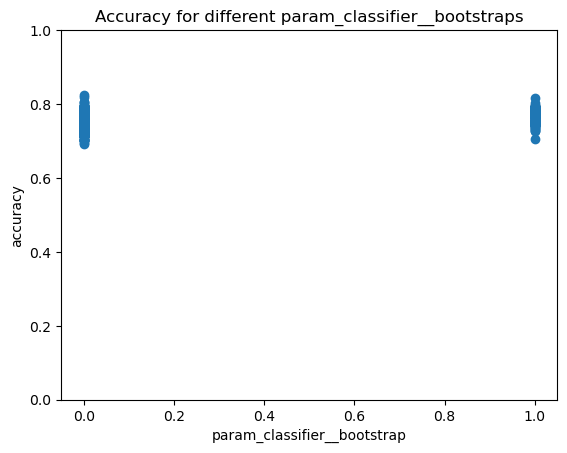

param_classifier__criterion


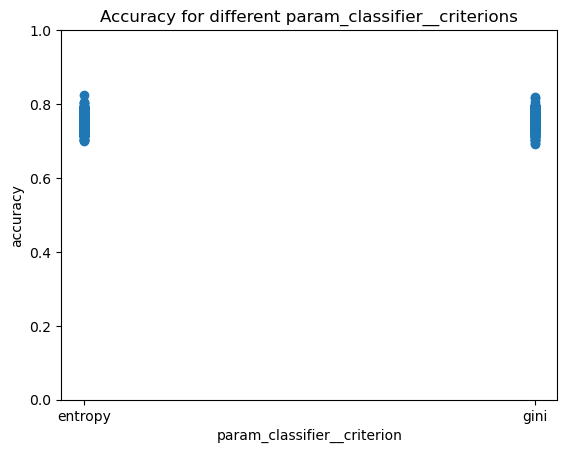

param_classifier__max_depth


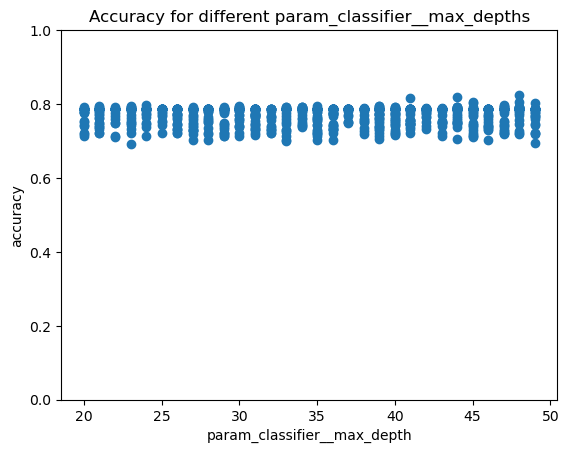

param_classifier__max_features


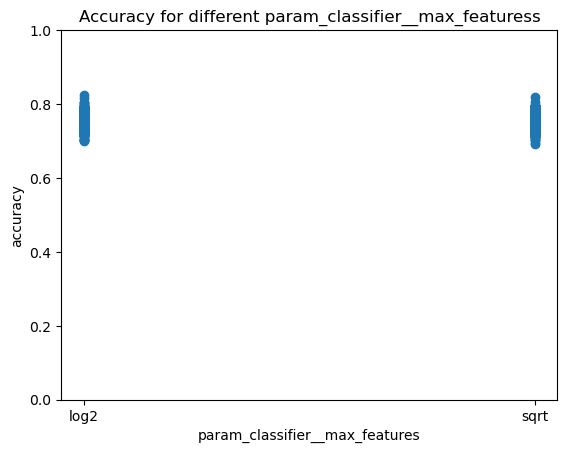

param_classifier__min_samples_leaf


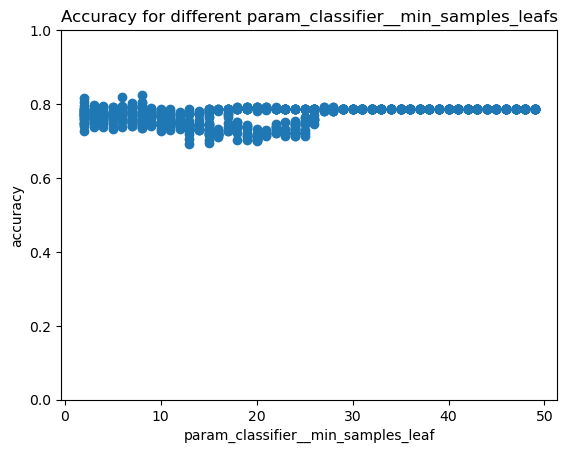

param_classifier__min_samples_split


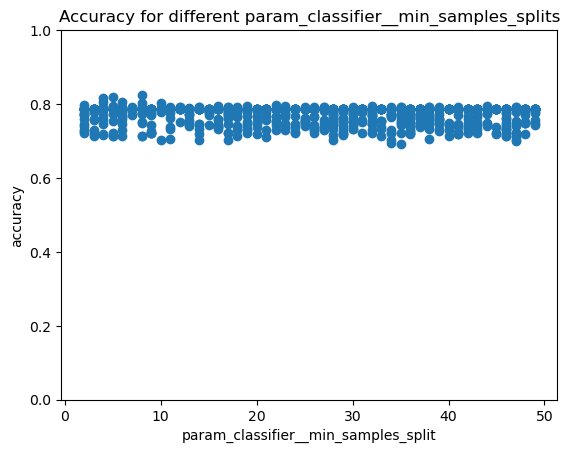

param_classifier__n_estimators


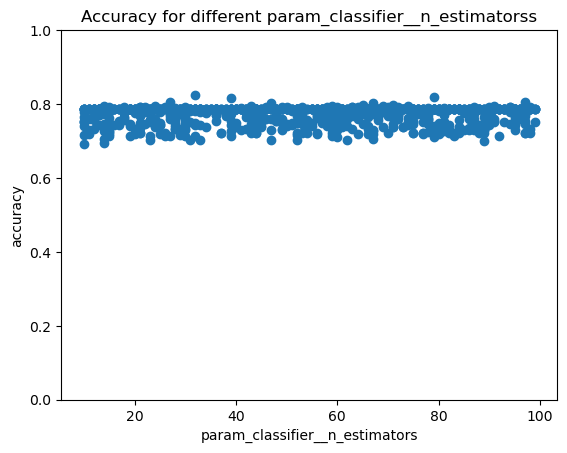

mean_test_score


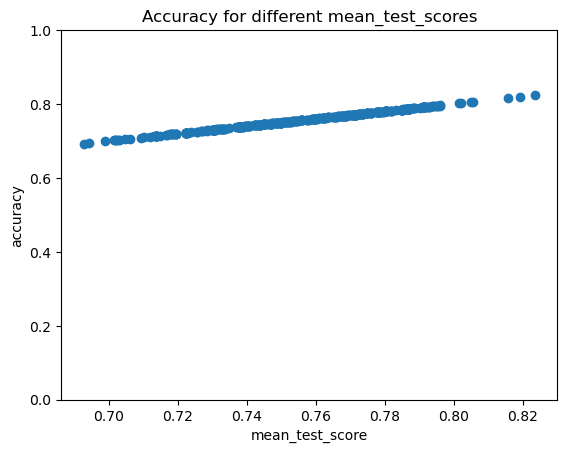

mean_train_score


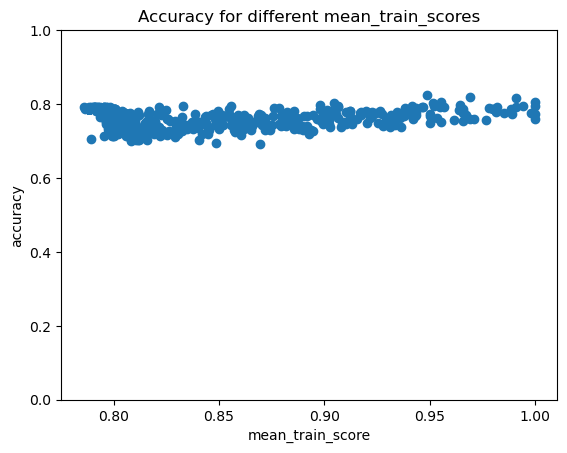

In [181]:
model_results = pd.DataFrame(grid_search.cv_results_)[['param_classifier__bootstrap', 'param_classifier__criterion',
       'param_classifier__max_depth', 'param_classifier__max_features',
       'param_classifier__min_samples_leaf', 'param_classifier__min_samples_split',
                                       'param_classifier__n_estimators','mean_test_score', 'mean_train_score' ]]
model_results.sort_values(by = 'mean_test_score', ascending = False, inplace = True)
print(model_results)
for col_name in list(model_results.columns):
    print(col_name)
    plt.clf()
    plt.scatter(model_results[col_name], model_results['mean_test_score'])
    plt.gca().set(xlabel='{}'.format(col_name), ylabel='accuracy', title='Accuracy for different {}s'.format(col_name))
    plt.gca().set_ylim([0,1])
    plt.show()

In [100]:
df= Cal(df_com).copy()
df.drop(['Open','High','Low', 'Volume'], axis = 1, inplace = True)
z = df.loc[((df['dir'].loc[df['dir'] == 'insf']).index)]
z.drop(['dir','Adj Close'], inplace= True, axis = 1)
df.dropna(inplace = True)
df.drop(index = z.index, inplace = True, axis = 0)
y = df['dir']
y = y.astype('int')
X = df.drop(['dir','Adj Close'], axis = 1)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.25, shuffle = True, train_size=0.75, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, shuffle = True, random_state = 42)

custom_scorer = make_scorer(f1_score, zero_division=1)

model = TPOTClassifier(generations=15, population_size=100, cv=KFold(n_splits = 5), scoring=custom_scorer, verbosity=2, random_state=1, n_jobs=2)
model.fit(X_train, y_train)
print('val score:', model.score(X_val,y_val))
print('test score:',model.score(X_test,y_test))

Optimization Progress:   0%|          | 0/1600 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8038440860215055

Generation 2 - Current best internal CV score: 0.8215389527458493

Generation 3 - Current best internal CV score: 0.8215389527458493

Generation 4 - Current best internal CV score: 0.8215389527458493

Generation 5 - Current best internal CV score: 0.8215389527458493

Generation 6 - Current best internal CV score: 0.8286223036223037

Generation 7 - Current best internal CV score: 0.8339043381535038

Generation 8 - Current best internal CV score: 0.8339043381535038

Generation 9 - Current best internal CV score: 0.8339043381535038

Generation 10 - Current best internal CV score: 0.8339043381535038

Generation 11 - Current best internal CV score: 0.8440934371523916

Generation 12 - Current best internal CV score: 0.8440934371523916

Generation 13 - Current best internal CV score: 0.8484089464484349

Generation 14 - Current best internal CV score: 0.8484089464484349

Generation 15 - Current best internal CV score: 0.848408

In [101]:
model.predict(z)

array([1, 1, 1])

In [102]:
model.predict(X_val)

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1])

In [ ]:
import keras as kr
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
model = kr.Sequential()
def setter(df):
    df.drop(['Open','High','Low', 'Volume'], axis = 1, inplace = True)
    z = df.loc[((df['dir'].loc[df['dir'] == 'insf']).index)]
    z.drop(['dir','Adj Close'], inplace= True, axis = 1)
    df.dropna(inplace = True)
    df.drop(index = z.index, inplace = True, axis = 0)
    y = df['dir']
    y = y.astype('int')
    X = df.drop(['dir','Adj Close'], axis = 1)
    return X,y
X,y = setter(df_com)

In [9]:
import tensorflow as tf
tf.random.set_seed(42)
def ML_port(X,y):
    input_shape = X.shape[1]
    scaler = StandardScaler()
    scaler.fit_transform(X)
    model = kr.Sequential()
    model.add(Dense(1000, activation = 'relu', input_shape = (input_shape,)))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(400, activation = 'relu'))
    model.add(Dropout(0.05))
    model.add(Dense(300, activation = 'relu'))
    model.add(Dense(150, activation = 'relu'))
    model.add(Dropout(0.05))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(30, activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    history = model.fit(X,y, epochs = 50, validation_split = 0.3, callbacks = [early_stopping], batch_size= 20)
    loss, accuracy = model.evaluate(X,y)
    return loss, accuracy, history
loss,accuracy, history = ML_port(X,y)


Epoch 1/50


C:\Users\Jerome\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4306 - loss: 0.7693 - val_accuracy: 0.4118 - val_loss: 0.7860
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4373 - loss: 0.7275 - val_accuracy: 0.4118 - val_loss: 0.7227
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3836 - loss: 0.7473 - val_accuracy: 0.5882 - val_loss: 0.6835
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4941 - loss: 0.7047 - val_accuracy: 0.5294 - val_loss: 0.6941
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6614 - loss: 0.6828 - val_accuracy: 0.5882 - val_loss: 0.6781
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5127 - loss: 0.6832 - val_accuracy: 0.4118 - val_loss: 0.7192
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5125 - loss: 0.6829 - val_accuracy: 0.5882 - val_loss: 0.6811
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4991 - loss: 0.6979 - val_accuracy: 0.4118 - val_loss: 0.7236
4/4 ━━━━━━━━━━

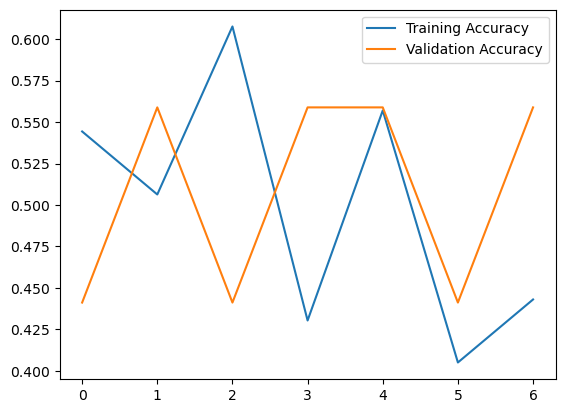

In [214]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [21]:
list = [1,2,3,4,5]
k = pd.DataFrame(columns = ['ticker', ])

,0
0,1
1,2
2,3
3,4
4,5


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
def ML_port(df):
    df.drop(['Open','High','Low', 'Volume'], axis = 1, inplace = True)
    z = df.loc[((df['dir'].loc[df['dir'] == 'insf']).index)]
    z.drop(['dir','Adj Close'], inplace= True, axis = 1)
    df.dropna(inplace = True)
    df.drop(index = z.index, inplace = True, axis = 0)
    y = df['dir']
    y = y.astype('int')
    X = df.drop(['dir','Adj Close'], axis = 1)
    print("A")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = True, train_size=0.75, random_state = 42)
    pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', AdaBoostClassifier(estimator = DecisionTreeClassifier(min_samples_leaf = 20, min_samples_split = 10, max_depth =5)))])
    param_grid = {
        'scaler__with_mean': [True, False],
        'scaler__with_std': [True, False],
        'classifier__n_estimators':[50,250,1000],
        'classifier__learning_rate':[0.01,0.1]
    }
    grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print(grid_search.predict(X_train))
    print("TRAIN SCORE: ",grid_search.score(X_train, y_train))
    print("TEST SCORE: ",grid_search.score(X_test, y_test))
    print(grid_search.predict(z))
ML_port(Cal(df_com))

In [ ]:
('classifier', LogisticRegression(max_iter=3000))
    ])
    param_grid = {
        'scaler__with_mean': [True, False],
        'scaler__with_std': [True, False],
        'classifier__penalty': ['l2'],
        'classifier__C': np.logspace(-3, 3, 7)

In [ ]:
df_new.columns

In [ ]:
df = data3.copy()
df.drop('Close', axis = 1, inplace = True)
df['dir'] = (df['Adj Close'].shift(-K) - df['Adj Close'])


In [ ]:
df.loc[df['dir'] > 0, 'dir'] = 1
df.loc[df['dir'] < 0, 'dir'] = 0
df['dir'] = df['dir'].fillna('insf')

In [ ]:
Low_60 = df['Adj Close'].rolling(window = 60, min_periods = 60).min()
High_60 = df['Adj Close'].rolling(window = 60, min_periods = 60).max()
Dif = High_60 - Low_60
def Low_cal(k):
    arr = Low_60 + (Dif * k)
    Parr = (df['Adj Close']/arr) -1
    return Parr
def High_cal(j):
    arr = High_60 - (Dif * j)
    Parr = (df['Adj Close']/arr) -1
    return Parr
df['SF1'] = Low_cal(0.382)
df['SF2'] = Low_cal(0.5)
df['SF3'] = Low_cal(0.618)
df['SF4'] = Low_cal(0.786)
df['RC1'] = High_cal(0.786)

In [ ]:
SMA = df['Adj Close'].rolling(window = 40, min_periods = 40).mean()
STD = df['Adj Close'].rolling(window = 40, min_periods = 40).std()
LBol = SMA - (3* STD)
HBol = SMA + (3* STD)
df['PLbol'] = ((df['Adj Close'] - LBol) / LBol) 
df['PHbol'] = ((df['Adj Close'] - HBol) / HBol)

In [ ]:
high_prices = df['High']
close_prices = df['Adj Close']
low_prices = df['Low']

nine_period_high =  df['High'].rolling(window=9).max()
nine_period_low = df['Low'].rolling(window=9).min()
tenkan_sen = (nine_period_high + nine_period_low) /2

period26_high = high_prices.rolling(window=26).max()
period26_low = low_prices.rolling(window=26).min()
kijun_sen = (period26_high + period26_low) / 2

senkou_span_a = ((tenkan_sen + kijun_sen) / 2).shift(26)

period52_high = high_prices.rolling(window=52).max()
period52_low = low_prices.rolling(window=52).min()
senkou_span_b = ((period52_high + period52_low) / 2).shift(26)

df['kumo'] = senkou_span_a - senkou_span_b
df['kijun_tenkan'] = tenkan_sen - kijun_sen


In [ ]:
ema12 = df['Adj Close'].ewm(span = 13,adjust=False, min_periods = 12).mean()
ema26 = df['Adj Close'].ewm(span = 26,adjust=False, min_periods = 26).mean()
MACD = ema12 - ema26
df['MACD'] = MACD
ema9 = df['MACD'].ewm(span = 9,adjust=False, min_periods = 9).mean()
df['ema9'] = ema9
#df['histo']= df['MACD'] - df['ema9']
df['MACD_grad'] = df['MACD'] - df['MACD'].shift(1)
df['ema9_grad'] = df['ema9'] - df['ema9'].shift(1)


In [ ]:
cup = df['Adj Close'].diff().copy()
cdown = df['Adj Close'].diff().copy()
cup[cup < 0] = 0
cdown[cdown > 0] = 0
cup_sum = cup.rolling(14, min_periods = 14).sum()
cdown_sum = cdown.rolling(14, min_periods = 14).sum() 
rsi_cal = cup_sum / (cdown_sum * -1)
RSI = 100 - (100/(1 + rsi_cal))
df['RSI'] = RSI

In [ ]:
def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=14):
    data_work = df.copy()
    high = data_work['High']
    low = data_work['Low']
    close = data_work['Adj Close']
    data_work['tr0'] = abs(high - low)
    data_work['tr1'] = abs(high - close.shift())
    data_work['tr2'] = abs(low - close.shift())
    tr = data_work[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

df['atr'] = atr(df, 14)

In [ ]:
df.drop(['Open','High','Low', 'Volume'], axis = 1, inplace = True)
z = df.loc[((df['dir'].loc[df['dir'] == 'insf']).index)]
z.drop(['dir','Adj Close'], inplace= True, axis = 1)
df.dropna(inplace = True)
df.drop(index = z.index, inplace = True, axis = 0)
y = df['dir']
y = y.astype('int')
X = df.drop(['dir','Adj Close'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = False, train_size=0.75)

In [ ]:
'''pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=3000))
])
param_grid = {
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False],
    'classifier__penalty': ['l2'],
    'classifier__C': np.logspace(-3, 3, 7)
}
luist_2 = {}
for i in range(5,13):
    grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits= i), scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print(i , ':', grid_search.score(X_test,y_test))
    luist_2[i] = grid_search.score(X_test,y_test)
    
max_value = max(luist_2, key=luist_2.get)
print("Best n_split is: ", max_value)'''

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=3000))
])
param_grid = {
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False],
    'classifier__penalty': ['l2'],
    'classifier__C': np.logspace(-3, 3, 7)
}
luist_2 = {}
for i in range(4,13):
    grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits= i), scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print(i , ':', grid_search.score(X_test,y_test))
    luist_2[i] = grid_search.score(X_test,y_test)
    
max_value = max(luist_2, key=luist_2.get)
print("Best n_split is: ", max_value)

In [ ]:
'''pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=30000))
])
lasso_param_grid = {
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False],
    'lasso__alpha': np.logspace(-3, 3, 7)
}
for i in range(2,14):
    grid_search = GridSearchCV(pipeline2, lasso_param_grid, cv=KFold(n_splits= i), scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print(i , ':', grid_search.score(X_test,y_test))'''

In [ ]:
abc = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits= max_value), scoring='accuracy')
abc.fit(X_train,y_train)
print(abc.score(X_train,y_train))
abc.predict(X_train)


In [ ]:
abc.best_estimator_['classifier'].fit(X_train,y_train).coef_

In [ ]:
z

In [ ]:
print("Ticker is: ", Ticker)
data.iloc[-K:]['Adj Close']


In [ ]:
print(abc.predict(z))
print("Train Confidence: ", abc.score(X_train,y_train)*100)
print("Test Confidence: ", abc.score(X_test,y_test)*100)

In [ ]:
list(data3.iloc[-K:]['Adj Close'])